In [615]:
import sys
sys.path.append('C:\\Users\\Patrick\\Documents\\GitHub\\ICDeepLearning\\Scripts')
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

from utils import path
from DataVis import createInputFigure
from NNUtils import *
from NNCreationAux import *
from SSVEPDataset import SSVEPDataset
from SSVEPDataloader import *
from classes import DenseBlock

from sklearn import preprocessing
import os
import time
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
def read_data(dataframe):
    return torch.tensor(pd.read_csv(dataframe['path'], sep = ' ', header = None, dtype = float).values)

def dataVisualization(X):
    fig = plt.figure(figsize = (15, 15))
    fig.tight_layout()
    ax = fig.add_subplot()
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.imshow(X, cmap = 'gray')

In [143]:
dataType = '512'
data = pd.read_csv('SSVEPDataset_'+dataType+'.csv')
dataset = SSVEPDataset(data, int(dataType))

batchSize = 64
dataloaders, datasetsSizes = SSVEPDataloaders(dataset, batchSize)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

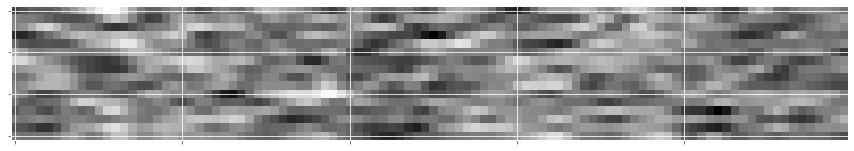

In [190]:
exemplo = next(iter(dataloaders['train']))[0][0][0]
dataVisualization(exemplo[:, :100])

In [204]:
exemplo = next(iter(dataloaders['train']))[0][0].unsqueeze(0)

In [212]:
conv = nn.Conv2d(1, 3, kernel_size = (1, 3), padding = (0, 1))

In [219]:
pool = nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2), return_indices = True)
unpool = nn.MaxUnpool2d(kernel_size = (1, 2), stride = (1, 2))

In [223]:
unpool(*pool(conv(exemplo))).shape

torch.Size([1, 3, 16, 512])

In [213]:
conv(exemplo).shape

torch.Size([1, 3, 16, 512])

In [616]:
dense = DenseBlock(1, 2, 1, 3)

In [618]:
dense(exemplo).shape

torch.Size([1, 2, 16, 512])

In [912]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        n1 = 8
        s = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size = (1, 2*n1 + 1), padding = (0, n1), stride = (1, s)),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace = True)
        )
        
        self.pool    = nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2), return_indices = True)
        self.unpool  = nn.MaxUnpool2d(kernel_size = (1, 2), stride = (1, 2))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3, 1, kernel_size = (1, 2*n1 + 1), padding = (0, n1), stride = (1, s), output_padding = (0, s - 1))
        )
        
    
    def forward(self, x):
        x = self.encoder(x)
        x, _2 = self.pool(x)
        x = self.unpool(x, _2)
        x = self.decoder(x)
        
        return x
    
    def encode(self, x):
        with torch.set_grad_enabled(False):
            x = self.encoder(x)
            x, _ = self.pool(x)
            
        return x

model = Autoencoder()
# model.encoder.state_dict()['0.weight']

In [913]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
model = model.to(device)
model, _, _ = train_autoencoder(model, dataloaders, datasetsSizes, criterion, optimizer, scheduler = None, num_epochs = 100)

--
Epoch 1/100
-----
Stage: train
Loss: 1.0653
Stage: val
Loss: 1.0286
--
Epoch 2/100
-----
Stage: train
Loss: 1.0016
Stage: val
Loss: 0.9718
--
Epoch 3/100
-----
Stage: train
Loss: 0.9495
Stage: val
Loss: 0.9254
--
Epoch 4/100
-----
Stage: train
Loss: 0.9064
Stage: val
Loss: 0.8847
--
Epoch 5/100
-----
Stage: train
Loss: 0.8673
Stage: val
Loss: 0.8459
--
Epoch 6/100
-----
Stage: train
Loss: 0.8293
Stage: val
Loss: 0.8072
--
Epoch 7/100
-----
Stage: train
Loss: 0.7911
Stage: val
Loss: 0.7684
--
Epoch 8/100
-----
Stage: train
Loss: 0.7522
Stage: val
Loss: 0.7286
--
Epoch 9/100
-----
Stage: train
Loss: 0.7129
Stage: val
Loss: 0.6888
--
Epoch 10/100
-----
Stage: train
Loss: 0.6740
Stage: val
Loss: 0.6501
--
Epoch 11/100
-----
Stage: train
Loss: 0.6364
Stage: val
Loss: 0.6132
--
Epoch 12/100
-----
Stage: train
Loss: 0.6013
Stage: val
Loss: 0.5794
--
Epoch 13/100
-----
Stage: train
Loss: 0.5694
Stage: val
Loss: 0.5493
--
Epoch 14/100
-----
Stage: train
Loss: 0.5412
Stage: val
Loss: 0.5231
-

In [906]:
model = model.to('cpu')
output = model(exemplo).detach()

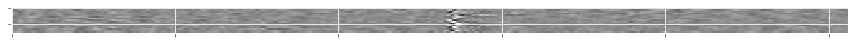

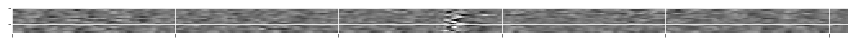

In [907]:
dataVisualization(exemplo.squeeze()[:, :512])
dataVisualization(output.squeeze()[:, :512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


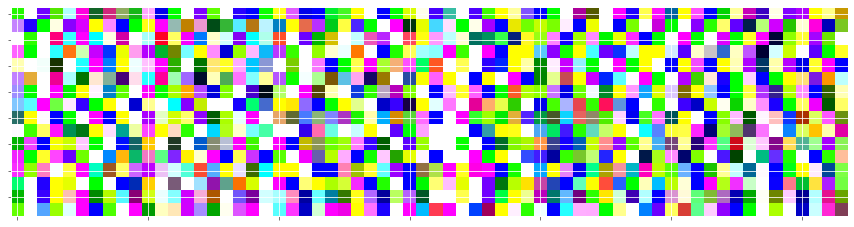

In [908]:
image = model.encode(exemplo).detach()[0]
image = (image.transpose(0, 2).transpose(0, 1).numpy())
fig = plt.figure(figsize = (15, 15))
fig.tight_layout()
ax = fig.add_subplot()
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.imshow(image)

In [910]:
class HybridModel(nn.Module):
    def __init__(self, encoder):
        super(HybridModel, self).__init__()
        self.encoder = encoder
        self.classifier = model_selection('resnet50', 5)
        
    def forward(self, x):
        with torch.set_grad_enabled(False):
            x = self.encoder(x)
        
        x = self.classifier(x)
        
        return x

In [911]:
hybrid = HybridModel(model.encoder)
hybrid = hybrid.to(device)
optimizer = optim.SGD(hybrid.parameters(), lr = 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()
hybrid, _, _ = train(hybrid, dataloaders, datasetsSizes, criterion, optimizer, scheduler, num_epochs = 10)

--
Epoch 1/10
-----
Stage: train
Loss: 1.5745 - Accuracy: 0.2990
Stage: val
Loss: 1.5315 - Accuracy: 0.3333
--
Epoch 2/10
-----
Stage: train
Loss: 1.2083 - Accuracy: 0.6071
Stage: val
Loss: 1.1884 - Accuracy: 0.5861
--
Epoch 3/10
-----
Stage: train
Loss: 0.7188 - Accuracy: 0.8246
Stage: val
Loss: 0.8763 - Accuracy: 0.7051
--
Epoch 4/10
-----
Stage: train
Loss: 0.3244 - Accuracy: 0.9336
Stage: val
Loss: 0.6596 - Accuracy: 0.7857
--
Epoch 5/10
-----
Stage: train
Loss: 0.1410 - Accuracy: 0.9794
Stage: val
Loss: 0.5600 - Accuracy: 0.8187
--
Epoch 6/10
-----
Stage: train
Loss: 0.0821 - Accuracy: 0.9881
Stage: val
Loss: 0.5557 - Accuracy: 0.8004
--
Epoch 7/10
-----
Stage: train
Loss: 0.1289 - Accuracy: 0.9693
Stage: val
Loss: 0.6185 - Accuracy: 0.8004
--
Epoch 8/10
-----
Stage: train
Loss: 0.3099 - Accuracy: 0.8956
Stage: val
Loss: 0.6853 - Accuracy: 0.7747
--
Epoch 9/10
-----
Stage: train
Loss: 0.2166 - Accuracy: 0.9327
Stage: val
Loss: 0.6905 - Accuracy: 0.7894
--
Epoch 10/10
-----
Stage: 

***

In [842]:
def train_autoencoder(model, dataloaders, dataset_size, criterion, optimizer, scheduler = None, num_epochs = 10):
    since = time.time()
    
    best_model_wgts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    trainLoss = []
    testLoss  = []
    
    for epoch in range(num_epochs):
        print('-'*2)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-'*5)
        
        for phase in ['train', 'val']:
            print('Stage: {}'.format(phase))
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            cumulative_loss = 0.0
            cumulative_hits  = 0
            
            for inputs, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                cumulative_loss += loss.item()*inputs.size(0)
                del(inputs); del(_)
                
            if phase == 'train' and scheduler != None:
                scheduler.step()
            
            epoch_loss = cumulative_loss / dataset_size[phase]
            
            if phase == 'train':
                trainLoss.append(epoch_loss)
            else:
                testLoss.append(epoch_loss)
                
            print('Loss: {:.4f}'.format(epoch_loss))
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wgts = copy.deepcopy(model.state_dict())
            
    time_elapsed = time.time() - since
    print('Best validation loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wgts)
    return model, best_loss, time_elapsed